In [1]:
import os
os.chdir('../')
import numpy as np
import torch as th
from glob import glob
from utils import *
import ray
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from alphagen.config import HORIZON_BACK

In [2]:
json_paths = glob('checkpoints/*ret1d*')
json_paths =    [sorted(
        glob(f"{name}/*.json"),
        key=lambda x: int(x.split("/")[-1].split("_")[0]),
    )[-1]
    for name in json_paths]

In [3]:
data = ArgData(start_time=20190103,end_time=20211231,device=torch.device('cpu'),max_backtrack_days=HORIZON_BACK)

In [4]:
def json_to_factor(path):  
    with open(path, "r") as f:
        alpha = json.load(f)
    factors = [
        Feature(getattr(FeatureType, expr[1:])).evaluate(data)
        if expr[0] == "$"
        else formula_to_expression(expr).evaluate(data)
        for expr in alpha["exprs"]
    ]
    weights = torch.tensor(alpha["weights"])
    factor_value = sum(f * w for f, w in zip(factors, weights))
    factor_value = normalize_by_day(factor_value)
    return factor_value

In [5]:
from concurrent.futures import ProcessPoolExecutor
alphas = []
with ProcessPoolExecutor(80) as executor:
    for value in zip(
        executor.map(
            json_to_factor,
            json_paths,
        ),
    ):
        alphas.append(value)


In [6]:
alphas[0][0].shape

torch.Size([11358, 6000])

In [7]:
sig_ret1d = th.stack([i[0] for i in alphas],dim=-1)

In [8]:
# sig_ret1d = th.concatenate([th.zeros(HORIZON_BACK,6000,len(alphas)),sig_ret1d],dim=0)

In [19]:
sig_ret1d = sig_ret1d[HORIZON_BACK:,...]

In [11]:
from alphagen_ocean.calculator import QLibStockDataCalculator

In [12]:
cal = QLibStockDataCalculator(data)

In [14]:
ret1d = cal.ret1d
ret2d = cal.ret2d
ret5d = cal.ret5d

In [21]:
ic = []
for i in range(sig_ret1d.shape[-1]):
    ic.append(batch_pearsonr(sig_ret1d[...,i],ret1d))

In [23]:
mean_ic = [th.mean(i) for i in ic]

In [25]:
split_idx = 486*16

In [137]:
demo = [0]*HORIZON_BACK+ ic[19].tolist()

In [138]:
demo = np.array(demo)

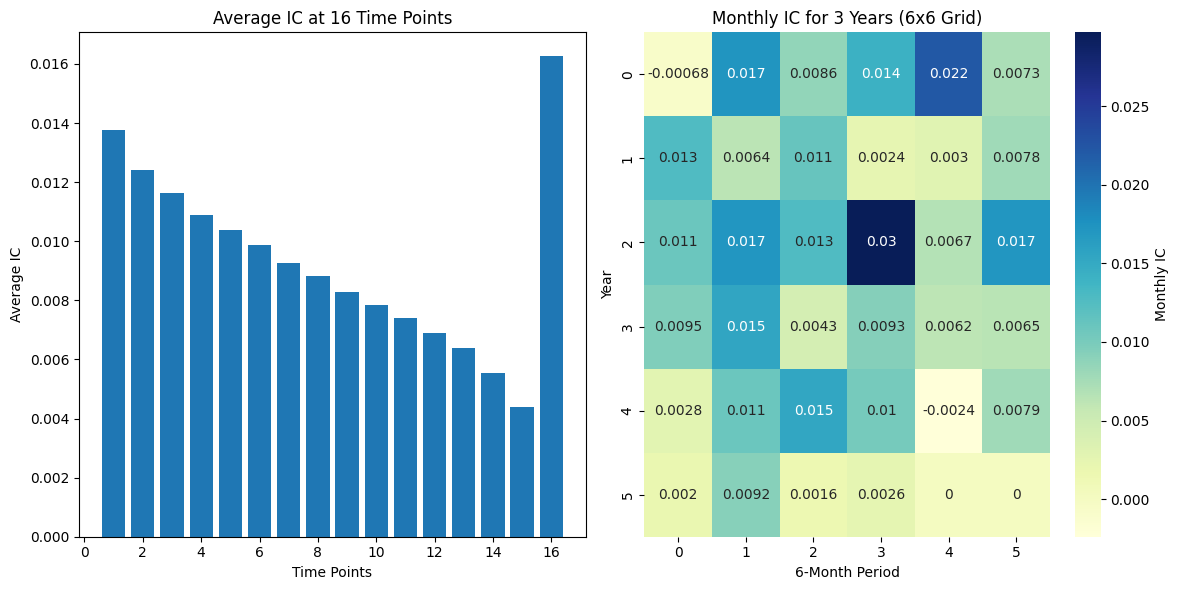

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 假设 demo 是一个一维数组，包含 11664 个 IC 值
# 这里我用随机数模拟这个数组

# 重新整形数组以匹配每天 16 个时间点
reshaped_demo = demo.reshape(-1, 16)

# 计算 16 个时间点上的平均 IC
average_ic_16_points = np.mean(reshaped_demo, axis=0)

# 计算月度 IC（假设每月有 21 个交易日）
# 首先，我们需要知道有多少个完整的月（21 天）
num_months = reshaped_demo.shape[0] // 21

# 然后，我们计算每个月的平均 IC
monthly_ic = np.mean(reshaped_demo[:num_months * 21].reshape(num_months, 21, 16), axis=1).mean(axis=1)

# 为了适应 6x6 的热图布局，我们需要重新整形月度 IC 数组
# 我们取前 36 个月的数据，如果不足则用 0 填充
padded_monthly_ic = np.pad(monthly_ic, (0, 36 - len(monthly_ic)), 'constant')
monthly_ic_reshaped = padded_monthly_ic.reshape(6, 6)

# 绘制图表
plt.figure(figsize=(12, 6))

# 16 个时间点上的平均 IC
plt.subplot(1, 2, 1)
plt.bar(range(1, 17), average_ic_16_points)
plt.xlabel('Time Points')
plt.ylabel('Average IC')
plt.title('Average IC at 16 Time Points')

# 每个月的平均 IC 热图
plt.subplot(1, 2, 2)
sns.heatmap(monthly_ic_reshaped, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Monthly IC'})
plt.xlabel('6-Month Period')
plt.ylabel('Year')
plt.title('Monthly IC for 3 Years (6x6 Grid)')

plt.tight_layout()
plt.show()
